In [1]:
from matplotlib import pyplot as plt
import csv
import numpy as np
import sys, os
import PIL # for reading tif images
import h5py
import datetime as dt
import time

results = "C:\\Networking Experiment\\artiq codes\\artiq-master\\results\\"
ms = 1e-3

def eval_str_from_h5(h5_str):
    """a stupid way to evaluate python evaluable strings I saved as ARTIQ datasets"""
    return eval(str(np.array(h5_str))[2:-1])

from scipy.optimize import curve_fit

sys.path.append("..\\")
from h5_data_utilities import * # helper functions for dealing with h5 files

def decay_fit(t, r, tau):
    """
    t: array of time points
    r: baseline retention
    f: oscillation frequency Omega/2pi
    C: contrast
    tau: exponential decay rate
    """
    return r*np.exp(-t/tau)

## 2024.10.02

In [2]:
fnames = get_files_by_criteria(date_filters=["2024-10-01"], # only find files from these dates. to include all dates in the 20s, do 2024-05-2
                               name_filters=["General"], # only find files containing all these strings
                               condition=lambda filename: True, # use this to filter by experiment parameters, like this: lambda filename: np.bool_(h5py.File(filename)['datasets']['set_current_coil_volts_at_finish'])
                               start_dir=results,
                               include_path=True, # only return the name of the file, not the full path
                               print_filenames=True
)
print(f"found {len(fnames)} files")
rid_list = [] 

scan_dictionary = {}
for i,f in enumerate(fnames):
    try:
        file = h5py.File(os.path.join(results, f))
        rid = file['rid'][()]
        if rid not in rid_list:
            rid_list.append(rid)
            ds = file['datasets']
            if "GeneralVariableScan" in f:
                try:
                    scan_var1 = str_from_h5(ds['scan_variable1_name'])
                    scan_str = scan_var1
                    if str_from_h5(ds['scan_variable2_name']) != '':
                        scan_str += ", " +str_from_h5(ds['scan_variable2_name'])
                    print(f"file {i} (...{f[len(results)-8:]}) scanned over "+scan_str)
                    scan_dictionary[f] = scan_var1
                except:
                    print(f"oops... something wrong with {f}")
            elif "GeneralVariableOptimizer" in f:
                optimizer_vars_dataset = [str(x)[1:] for x in ds['optimizer_vars_dataset']]
                cost_function = str(ds['cost_function'][()])[1:]
                print(f"file {i} (...{f[len(results)-8:]}) optimized {optimizer_vars_dataset} for {cost_function}")
    except OSError:
        pass # if rid wasn't in the file, its corrupt
    finally:
        file.close()
print(f"skipped {len(fnames)-len(rid_list)} redundant files")
scan_groups = {}

for key,val in scan_dictionary.items():
    if not val in scan_groups:
        scan_groups[val] = []
    scan_groups[val].append(key)
print(f"{len(scan_groups)} scan_variables over {len(scan_dictionary)} variable scans")

found 8 files
file 0 (...results\2024-10-01\16\000017951-GeneralVariableScan.h5) scanned over t_delay_between_shots
file 2 (...results\2024-10-01\16\000017952-GeneralVariableScan.h5) scanned over t_FORT_drop
file 4 (...results\2024-10-01\17\000017953-GeneralVariableScan.h5) scanned over t_FORT_drop
file 6 (...results\2024-10-01\17\000017954-GeneralVariableScan.h5) scanned over t_FORT_drop
skipped 4 redundant files
2 scan_variables over 4 variable scans


experiment: atom_loading_experiment
override: {'require_atom_loading_to_advance':False}
r=1.0000, tau=3.8568
saved file to  atom_loading_experiment 17951.svg


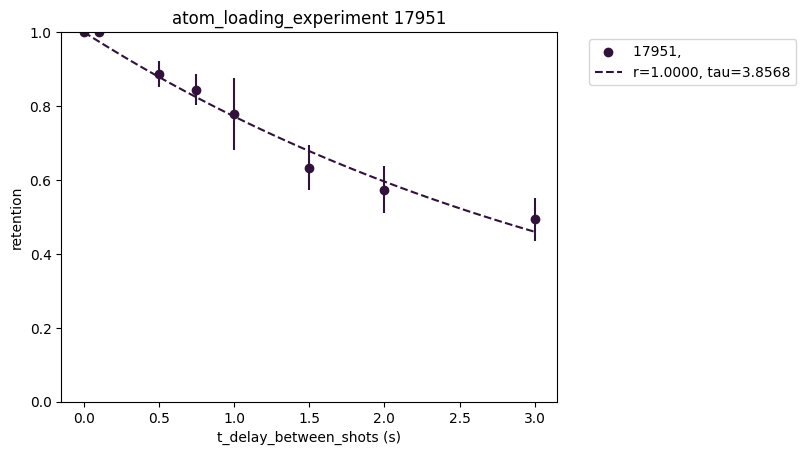

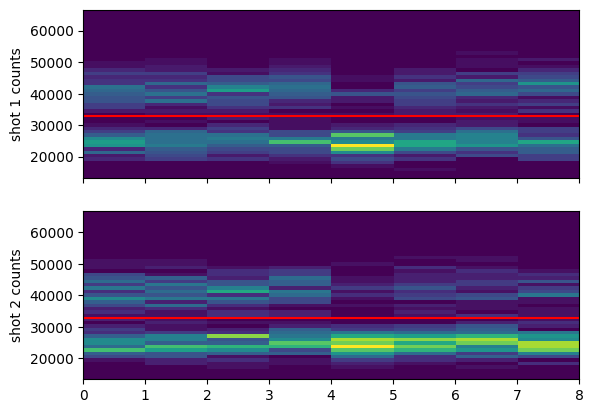

In [6]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don't try this in 2D
fit = True

cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    0: ''
} # the files to plot

legend_vars =[]
# legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend

xform_and_label = {'t_delay_between_shots': {'xsteps_xform': lambda x: x, 'xlabel': "t_delay_between_shots (s)"},
                   'f_microwaves_dds':{'xsteps_xform': lambda x: (x - 334.682e6)*1e-3, 'xlabel':r"$\rm{f\_microwaves\_dds} - 334.682 MHz  ~(\rm kHz)$"},
                   't_microwave_pulse':{'xsteps_xform': lambda x: 1e6*x, 'xlabel': "t_microwave_pulse (us)"},
                   't_pumping': {'xsteps_xform': lambda x: 1e3*x, 'xlabel': "t_pumping (ms)"}}

# loc=(1.05,0.05)
# loc='lower left' 
# loc='upper right'
loc='best'

fit_dict = {'t_delay_between_shots': {'model':decay_fit, 'p0':[0.95, 2.0], 'params':['r', 'tau'], 'bounds':[[0.0,0.01],[1.0,10.0]]},
            # 'f_microwaves_dds': {'model':resonance_dip_fit, 'p0':[0.9, 30e3, 334682000 + 5e3, 0.4], 'params':['r', 'sigma', 'f0', 'C'], 'bounds':(-np.inf, np.inf)}, # (-inf, inf) is default for curve fit
            # 't_microwave_pulse': {'model':Rabi_oscillation_fit, 'p0':[0.95, 33e3, 0.8, 0.006], 'params':['r', 'Omega/2*pi', 'C', 'tau'], 'bounds':[[0,1e2,0,0],[1,1e5,1,1e-2]]}
           }

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)
    
    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu='otsu_threshold')

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = binomial_err(n_loaded, retention)
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = binomial_err(n_loaded, loading)
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

title = experiment_function+' '+str(rid)
savename = title.replace(',','_') + '.svg'
plt.savefig(savename, bbox_inches='tight')
print("saved file to ", savename)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

In [13]:
0x00000f == 15

True

In [18]:
0x000032

50

In [17]:
0x00000a == 10

True

In [20]:
0xe0

224

experiment: microwave_Rabi_experiment
override: {'require_atom_loading_to_advance':False, 'AY_volts_OP':5.0, 'f_microwaves_dds':334690472.9}
r=0.9565, Omega/2*pi=36443.4531, C=0.8741, tau=0.0017


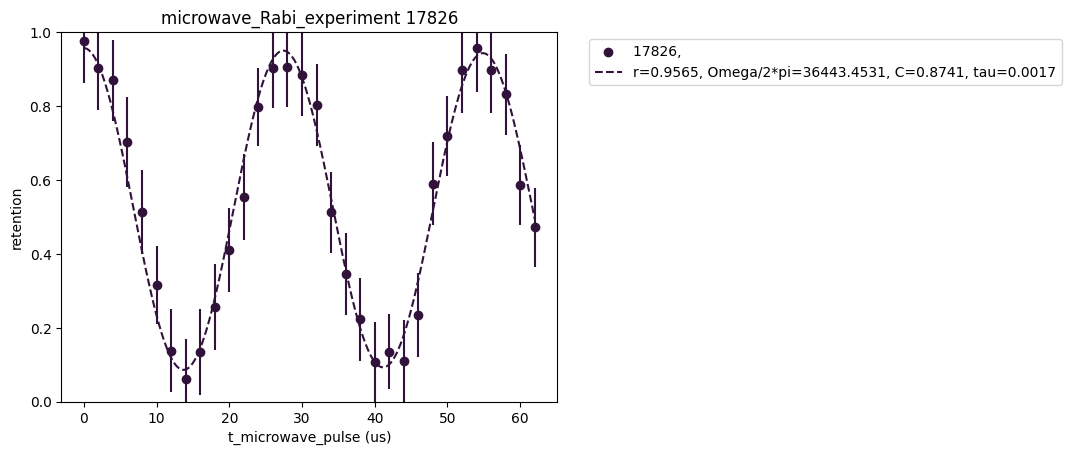

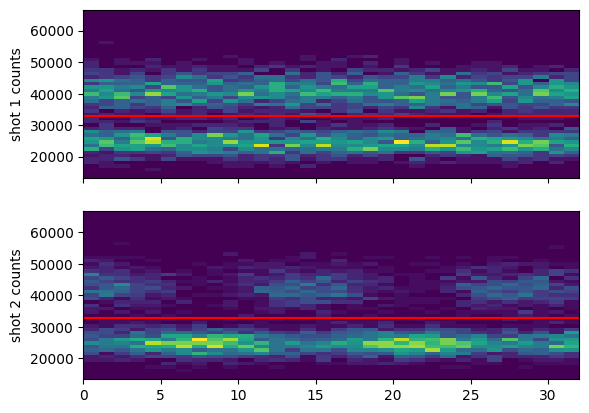

In [78]:
compare = True # compare multiple files in the same retention and loading plots
otsu_threshold = True # compute threshold using Otsu method instead doing it by eye. only work when require atom loading = False
showhist = True
showloading = False
custom_xlabel = True
merge_data = False # the datasets will be combined, and if fit=True, the new merged data will be fit. don'ttry this in 2D
fit = True

cutoff1 = cutoff2 = 492 # threshold in units counts. remember, we don't measure a count rate. ignored if otsu_threshold.

file_indices = {
    # 9: '', # looks familiar
    # # 15: '' # OP came unlocked but didn't trip the lock monitor, so probably we need to adjust the boundaries on the card
    # 33: '',
    37: ''
} # the files to plot

legend_vars =[]
# legend_vars = ['AY_volts_OP', 'f_microwaves_dds'] # will be included in the plot legend

xform_and_label = {'f_microwaves_dds':{'xsteps_xform': lambda x: (x - 334.682e6)*1e-3, 'xlabel':r"$\rm{f\_microwaves\_dds} - 334.682 MHz  ~(\rm kHz)$"},
                   't_microwave_pulse':{'xsteps_xform': lambda x: 1e6*x, 'xlabel': "t_microwave_pulse (us)"},
                   't_pumping': {'xsteps_xform': lambda x: 1e3*x, 'xlabel': "t_pumping (ms)"}}

# loc=(1.05,0.05)
# loc='lower left' 
# loc='upper right'
loc='best'

fit_dict = {'f_microwaves_dds': {'model':resonance_dip_fit, 'p0':[0.9, 30e3, 334682000 + 5e3, 0.4], 'params':['r', 'sigma', 'f0', 'C'], 'bounds':(-np.inf, np.inf)}, # (-inf, inf) is default for curve fit
            't_microwave_pulse': {'model':Rabi_oscillation_fit, 'p0':[0.95, 33e3, 0.8, 0.006], 'params':['r', 'Omega/2*pi', 'C', 'tau'], 'bounds':[[0,1e2,0,0],[1,1e5,1,1e-2]]}}

if compare:
    if showloading:
        fig_ret,axes = plt.subplots(nrows=2, sharex=True)
        ax_ret, ax_ldng = axes
    else:
        fig_ret,ax_ret = plt.subplots()
ret_cmap = mpl.colormaps['turbo']
ldng_cmap = mpl.colormaps['winter']

first_shot_hists = []
second_shot_hists = []
mean1_by_iteration = []
mean2_by_iteration = []

merged_retention = np.empty([0])
merged_scan_sequence1 = np.empty([0])
merged_errs = np.empty([0])
rid_str = ''

for idx,f_item in enumerate(file_indices.items()):
    f_idx,f_comment = f_item
    f = h5py.File(os.path.join(results, fnames[f_idx]))
    rid = f['rid'][()]
    h5_archive_and_datasets_to_locals(f, parent_locals=locals(), quiet=True)
    print("experiment:",experiment_function)
    print("override:",override_ExperimentVariables)

    iterations = len(scan_sequence1) #int(len(photocounts)/n_measurements)

    xsteps_xform,xlabel = (xform_and_label[scan_variable1_name]['xsteps_xform'],xform_and_label[scan_variable1_name]['xlabel']) if scan_variable1_name in xform_and_label and custom_xlabel else (lambda x: x, scan_variable1_name)
    
    legend_string = ''
    for a in legend_vars:
        legend_string += f'{a}={locals()[a]}, '
    legend_string = legend_string[:-2]
    f_comment += legend_string

    retention_array, loading_rate_array, n_atoms_loaded_array = get_loading_and_retention(photocounts,photocounts2,n_measurements,iterations,cutoff1,otsu='otsu_threshold')

    ncols = len(scan_sequence2)
    nrows = len(scan_sequence1)
    shape = (len(scan_sequence2),len(scan_sequence1))
    loading_rate_raveled = np.reshape(loading_rate_array,shape,order='F') # rows have constant variable2
    n_atoms_loaded_raveled = np.reshape(n_atoms_loaded_array,shape,order='F') # rows have constant variable2
    retention_raveled = np.reshape(retention_array,shape,order='F') # rows have constant variable2
    
    if showhist:
        first_shot_hists.append(
            [np.histogram(photocounts[i*n_measurements:(i+1)*n_measurements]/t_SPCM_first_shot,bins=np.linspace(200,1000,50)/t_SPCM_first_shot)[0]
                              for i in range(iterations)])

        second_shot_hists.append(
            [np.histogram(photocounts2[i*n_measurements:(i+1)*n_measurements]/t_SPCM_second_shot,bins=np.linspace(200,1000,50)/t_SPCM_second_shot)[0]
                                      for i in range(iterations)])

        mean1_by_iteration.append([np.mean(photocounts[i*n_measurements:(i+1)*n_measurements][photocounts[i*n_measurements:(i+1)*n_measurements] < cutoff1]/t_SPCM_first_shot) 
                              for i in range(iterations)])
        mean2_by_iteration.append([np.mean(photocounts2[i*n_measurements:(i+1)*n_measurements][photocounts2[i*n_measurements:(i+1)*n_measurements] < cutoff2]/t_SPCM_second_shot) 
                              for i in range(iterations)])
    
    # plot a retention curve vs variable 1 for each variable 2 value
    for i, retention, loading, n_loaded, var2 in zip(range(len(scan_sequence2)),retention_raveled, loading_rate_raveled, n_atoms_loaded_raveled, scan_sequence2):
        
        errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
        if not compare:
            if showloading:
                    fig_ret,axes = plt.subplots(nrows=2, sharex=True)
                    ax_ret, ax_ldng = axes
            else:
                fig_ret,ax_ret = plt.subplots()
                
        if not merge_data:
            ax_ret.scatter(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], label=str(rid)+', '+f_comment, color=ret_cmap(idx/len(file_indices)))
            ax_ret.errorbar(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0], errs[loading > 0], ls='none',color=ret_cmap(idx/len(file_indices)))
            ax_ret.set_ylim((0,1))

            if not ncols > 1 and fit and scan_variable1_name in fit_dict:
                popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
                fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
                print(fit_str)
                hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
                hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
                ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color=ret_cmap(idx/len(file_indices)),label=fit_str)
            else:
                ax_ret.plot(xsteps_xform(scan_sequence1)[loading > 0], retention[loading > 0],linestyle='--',color=ret_cmap(idx/len(file_indices)))
    
            if not showloading:
                ax_ret.set_xlabel(xlabel)
            ax_ret.set_ylabel("retention")
            #ax_ret.legend(loc=loc)
            ax_ret.legend(bbox_to_anchor=(1.05, 1), loc='upper left')      # This will show the legend outside the plot
            
        else:
            merged_retention = np.concatenate((merged_retention,retention[loading > 0]))
            merged_scan_sequence1 = np.concatenate((merged_scan_sequence1, scan_sequence1[loading > 0]))
            merged_errs = np.concatenate((merged_errs, errs[loading > 0]))
            rid_str += str(rid) + ', '
    
        if showloading:
            ax_ldng.plot(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], linestyle='--',color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.scatter(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], label=rid, color=ldng_cmap(idx/len(file_indices)))
            errs = np.array([1/np.sqrt(n) if n > 0 else np.inf for n in n_loaded])
            ax_ldng.errorbar(xsteps_xform(scan_sequence1)[loading > 0], loading[loading > 0], errs[loading > 0], ls='none', color=ldng_cmap(idx/len(file_indices)))
            ax_ldng.set_ylim((0,1))
            ax_ldng.set_xlabel(xlabel)
            ax_ldng.set_ylabel("loading rate")

if merge_data:
    retention = merged_retention
    scan_sequence1 = merged_scan_sequence1
    errs = merged_errs

    ax_ret.scatter(xsteps_xform(scan_sequence1), retention, color='plum')
    ax_ret.errorbar(xsteps_xform(scan_sequence1), retention, errs, ls='none',color='plum')
    ax_ret.set_ylim((0,1))
    
    if not ncols > 1 and fit and scan_variable1_name in fit_dict:        
        popt, _ = curve_fit(f=fit_dict[scan_variable1_name]['model'], xdata=scan_sequence1, ydata=retention, p0=fit_dict[scan_variable1_name]['p0'], bounds=fit_dict[scan_variable1_name]['bounds'])
        hi_res_x = np.linspace(scan_sequence1[0], scan_sequence1[-1], 10*len(scan_sequence1))
        hi_res_x_xform = np.linspace(xsteps_xform(scan_sequence1)[0], xsteps_xform(scan_sequence1)[-1], 10*len(scan_sequence1))
        fit_str = "".join([f'{p}={v:.4f}, ' for p,v in zip(fit_dict[scan_variable1_name]['params'], popt)])[:-2]
        print(fit_str)
        ax_ret.plot(hi_res_x_xform, fit_dict[scan_variable1_name]['model'](hi_res_x, *popt),linestyle='--',color='violet', label=fit_str)
        ax_ret.legend()
    else:
        ax_ret.plot(xsteps_xform(scan_sequence1), retention,linestyle='--',color='violet')


if not compare or len(file_indices)==1:
    ax_ret.set_title(experiment_function+' '+str(rid))
elif merge_data:
    ax_ret.set_title(experiment_function+' '+ rid_str[:-2])
else:
    ax_ret.set_title(experiment_function)

if showhist:
    fig,axes = plt.subplots(nrows=2,sharex=True)
    ax,ax2 = axes
    cax=ax.imshow(np.array(first_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax.set_ylabel("shot 1 counts")
    ax.axhline(cutoff1/t_SPCM_first_shot,color='red')
    ax.set_aspect('auto')
    cax2=ax2.imshow(np.array(second_shot_hists[0]).transpose(),origin='lower',extent=[0,iterations,200/t_SPCM_first_shot,1000/t_SPCM_first_shot])
    ax2.set_ylabel("shot 2 counts")
    ax2.axhline(cutoff2/t_SPCM_first_shot,color='red')
    ax2.set_aspect('auto')
plt.show()

## January 2024

### 2023.12.24

In [2]:
f = h5py.File(os.path.join(results, "2023-12-24\\14\\000008985-SingleAtomTrapLifetime.h5"))
# [x for x in f['datasets']]

In [12]:
[x for x in f['archive']]

['AOM_A1_freq',
 'AOM_A1_power',
 'AOM_A2_freq',
 'AOM_A2_power',
 'AOM_A3_freq',
 'AOM_A3_power',
 'AOM_A4_freq',
 'AOM_A4_power',
 'AOM_A5_freq',
 'AOM_A5_power',
 'AOM_A6_freq',
 'AOM_A6_power',
 'AX_volts_MOT',
 'AX_volts_OP',
 'AX_volts_PGC',
 'AX_volts_RO',
 'AY_volts_MOT',
 'AY_volts_OP',
 'AY_volts_PGC',
 'AY_volts_RO',
 'AZ_bottom_volts_MOT',
 'AZ_bottom_volts_OP',
 'AZ_bottom_volts_PGC',
 'AZ_bottom_volts_RO',
 'AZ_top_volts_MOT',
 'AZ_top_volts_OP',
 'AZ_top_volts_PGC',
 'AZ_top_volts_RO',
 'Luca_trigger_for_feedback_verification',
 'MOT5_fW_Thor_monitor',
 'MOT5_fW_monitor',
 'MOT_beam_monitor_points',
 'Vx_array',
 'Vy_array',
 'Vz_bottom_array',
 'Vz_top_array',
 '[-1.5 - i*(3.3 - 1.5)',
 '[0.025 - k*(0.9 + 0.025)',
 '[0.15 - j*(0.8 + 0.15)',
 '[0.6 - l*(0.6 - 1)',
 'aom_feedback_averages',
 'aom_feedback_iterations',
 'blowaway_light_off',
 'cooling_setpoint_mW',
 'cooling_volts_ch',
 'do_PGC_after_loading',
 'enable_laser_feedback',
 'fW_Thor_monitor',
 'f_D1_pumping_SP

In [27]:
# parameters loaded from datasets set in experiment variables are in archive. those set in the experiment itself are in datasets

n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots_sequence'])
t_exp = np.float64(f['archive']['t_SPCM_first_shot'])

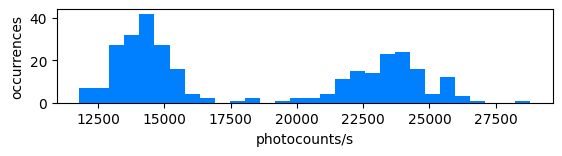

loading rate 0.43666666666666665


In [36]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = 300
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

i = 3
shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]

fig,ax = plt.subplots()
# plt.hist((shot1-np.mean(shot1[shot1<270]))/t_exp,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
ax.hist((shot1)/t_exp,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
# plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')

# plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
# plt.title(f"t={t/ms}ms")
ax.set_xlabel("photocounts/s")
ax.set_ylabel("occurrences")
aspect = 80
ax.set_aspect(aspect)
plt.dpi = 200
# plt.savefig("2023-12-24_atom_loading_histogram_counts_per_s_zero_background2.jpg",bbox_inches='tight')
# plt.savefig("2023-12-24_atom_loading_histogram_counts_per_s_2.jpg",bbox_inches='tight')
# plt.savefig("2023-12-24_atom_loading_histogram_counts_per_s_2.jpg",bbox_inches='tight')
plt.savefig(f"2023-12-24_atom_loading_histogram_counts_per_s_aspect{aspect}.jpg",bbox_inches='tight')

plt.show()
atoms_loaded = [x > cutoff for x in shot1]
n_atoms_loaded = sum(atoms_loaded)
atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
retention_array[i] = retention_fraction
loading_rate_array[i] = n_atoms_loaded/n_measurements
print("loading rate",loading_rate_array[i])
n_atoms_loaded_array[i] = n_atoms_loaded

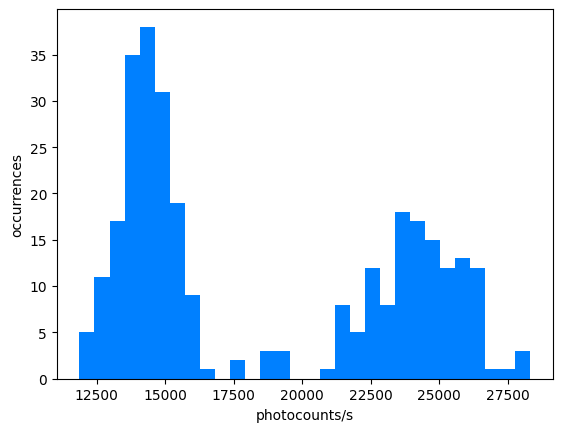

loading rate 0.42


In [16]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = 300
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

i = 0
shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
plt.hist(shot1/t_exp,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
# plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
# plt.title(f"t={t/ms}ms")
plt.xlabel("photocounts/s")
plt.ylabel("occurrences")
plt.dpi = 200
plt.savefig("2023-12-24_atom_loading_histogram_counts_per_s_zero_background.jpg",bbox_inches='tight')
plt.show()
atoms_loaded = [x > cutoff for x in shot1]
n_atoms_loaded = sum(atoms_loaded)
atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
retention_array[i] = retention_fraction
loading_rate_array[i] = n_atoms_loaded/n_measurements
print("loading rate",loading_rate_array[i])
n_atoms_loaded_array[i] = n_atoms_loaded

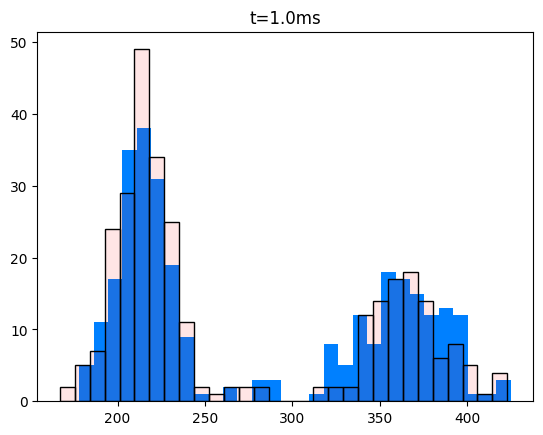

loading rate 0.42


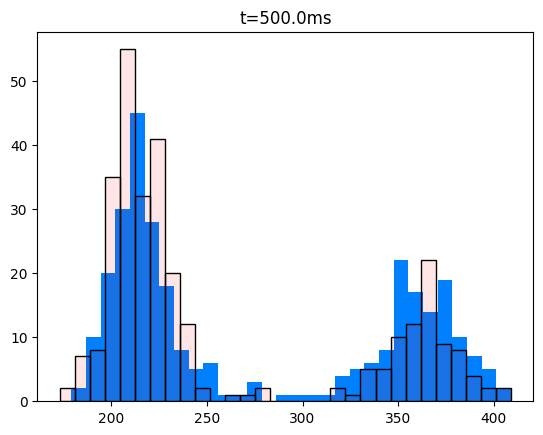

loading rate 0.4033333333333333


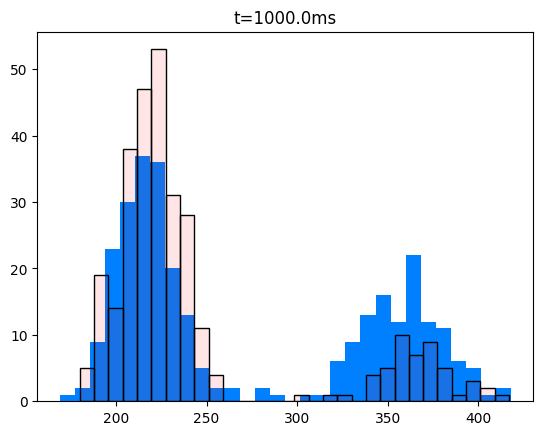

loading rate 0.39


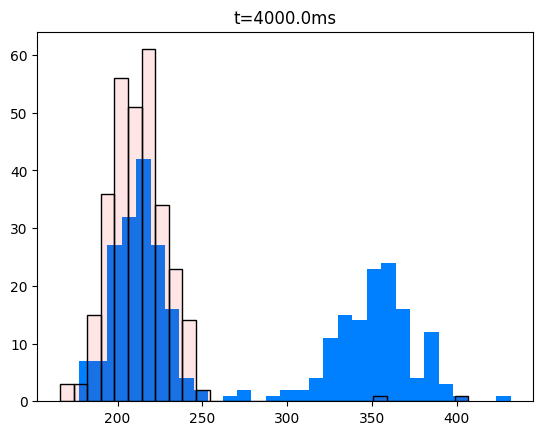

loading rate 0.43666666666666665


In [5]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = 300
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    plt.title(f"t={t/ms}ms")
    plt.show()
    atoms_loaded = [x > cutoff for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    print("loading rate",loading_rate_array[i])
    n_atoms_loaded_array[i] = n_atoms_loaded

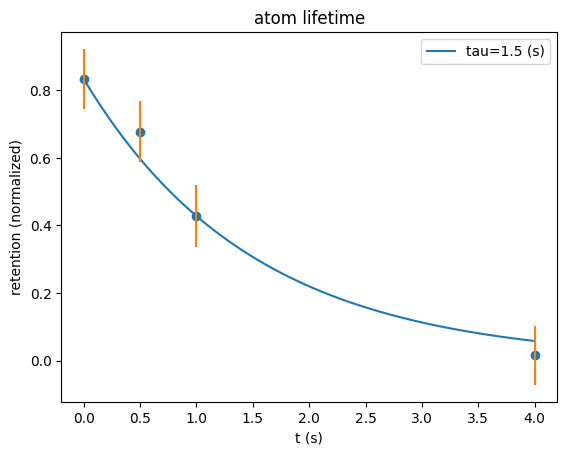

In [13]:
plt.scatter(t_delay_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
tau = 1.5
plt.title('atom lifetime')
plt.plot(t_pts,retention_array[0]*np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.errorbar(t_delay_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention (normalized)")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
plt.legend()

## November 2023

### 2023.11.21

#### diagnose baseline retention
The retention with a very short holding time should be > 90% unless the atoms are really hot, being significantly heated by the readout, or being heated out by RIN from the FORT light.

In [235]:
f = h5py.File(os.path.join(results, "2023-11-21\\10\\000007904-SingleAtomTrapLifetime.h5"))

In [236]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots'])
print("MOT AOMs on the whole time?", np.bool_(f['datasets']['MOT_AOMs_always_on']))
print("PGC phase?", np.bool_(f['datasets']['do_PGC_after_loading']))

MOT AOMs on the whole time? False
PGC phase? False


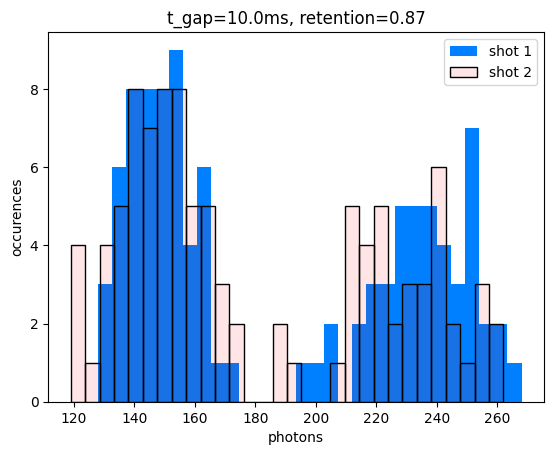

In [262]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=30, facecolor=(0.0, 0.5, 1, 1),label='shot 1')
    plt.hist(shot2,bins=30, facecolor=(1.0, 0.0, 0.0, 0.1),label='shot 2', edgecolor=(0, 0, 0, 1), linestyle='-')
    
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

    plt.title(f"t_gap={t/ms}ms, retention={retention_fraction:.2f}")
    plt.ylabel("occurences")
    plt.xlabel("photons")
    plt.legend()
    plt.show()

In [243]:
plt.hist?

Signature:
plt.hist(
    x: 'ArrayLike | Sequence[ArrayLike]',
    bins: 'int | Sequence[float] | str | None' = None,
    range: 'tuple[float, float] | None' = None,
    density: 'bool' = False,
    weights: 'ArrayLike | None' = None,
    cumulative: 'bool | float' = False,
    bottom: 'ArrayLike | float | None' = None,
    histtype: "Literal['bar', 'barstacked', 'step', 'stepfilled']" = 'bar',
    align: "Literal['left', 'mid', 'right']" = 'mid',
    orientation: "Literal['vertical', 'horizontal']" = 'vertical',
    rwidth: 'float | None' = None,
    log: 'bool' = False,
    color: 'ColorType | Sequence[ColorType] | None' = None,
    label: 'str | Sequence[str] | None' = None,
    stacked: 'bool' = False,
    *,
    data=None,
    **kwargs,
) -> 'tuple[np.ndarray | list[np.ndarray], np.ndarray, BarContainer | Polygon | list[BarContainer | Polygon]]'
Docstring:
Compute and plot a histogram.

This method uses `numpy.histogram` to bin the data in *x* and count the
number of values in eac

### 2023.11.20

#### with PGC phase after MOT

In [264]:
f = h5py.File(os.path.join(results, "2023-11-20\\17\\000007897-SingleAtomTrapLifetime.h5"))
# [x for x in f['datasets']]

In [265]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots'])
print("MOT AOMs on the whole time?", np.bool_(f['datasets']['MOT_AOMs_always_on']))
print("PGC phase?", np.bool_(f['datasets']['do_PGC_after_loading']))

MOT AOMs on the whole time? False
PGC phase? True


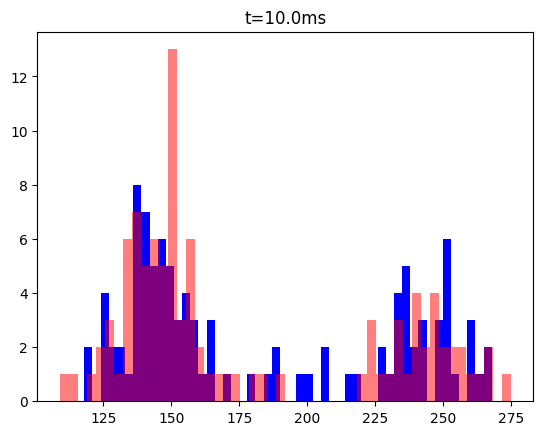

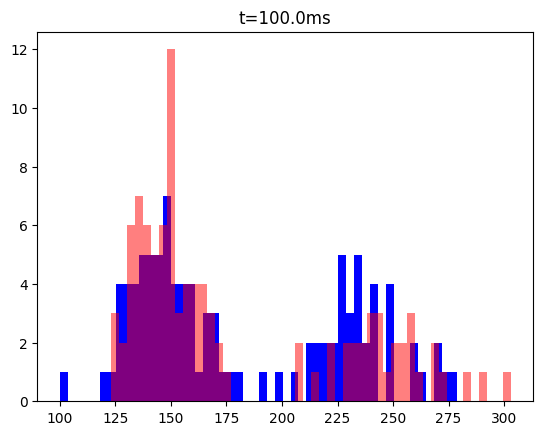

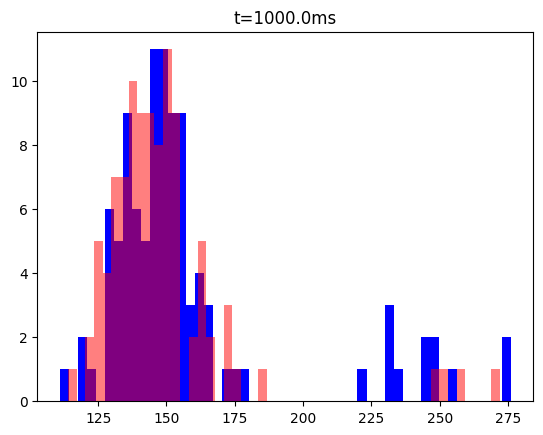

In [266]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
    plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
    plt.title(f"t={t/ms}ms")
    plt.show()
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

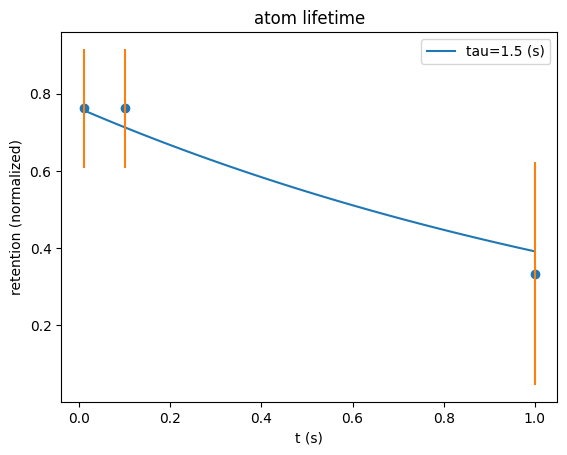

In [269]:
plt.scatter(t_delay_arr, retention_array)
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
tau = 1.5
plt.title('atom lifetime')
plt.plot(t_pts,retention_array[0]*np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.errorbar(t_delay_arr,retention_array,1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention (normalized)")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
plt.legend()

#### with MOT AOMs on the whole time
if the readout is heating the atom, the lifetime should go down

In [271]:
f = h5py.File(os.path.join(results, "2023-11-20\\16\\000007889-SingleAtomTrapLifetime.h5"))
# [x for x in f['datasets']]

In [272]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots'])
print("MOT AOMs on the whole time?", np.bool_(f['datasets']['MOT_AOMs_always_on']))
print("PGC phase?", np.bool_(f['datasets']['do_PGC_after_loading']))

MOT AOMs on the whole time? True
PGC phase? False


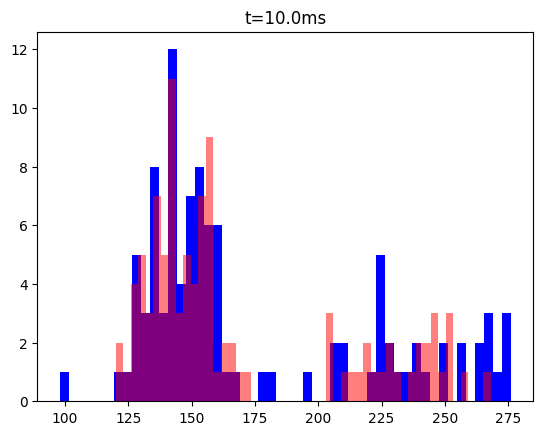

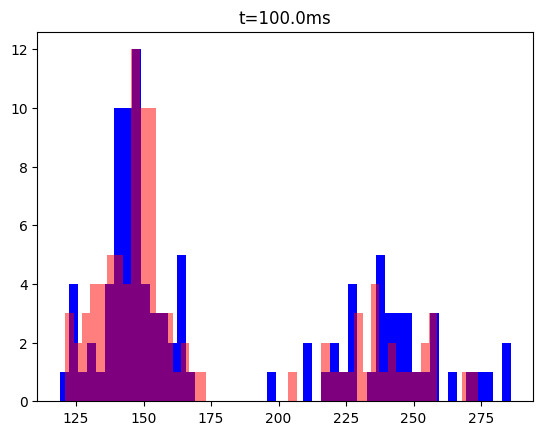

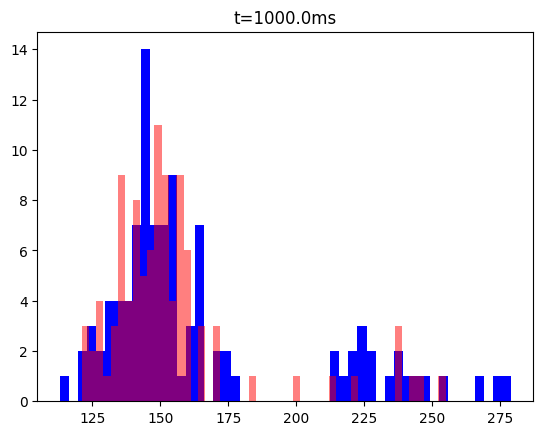

In [273]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180]*4
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
    plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
    plt.title(f"t={t/ms}ms")
    plt.show()
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

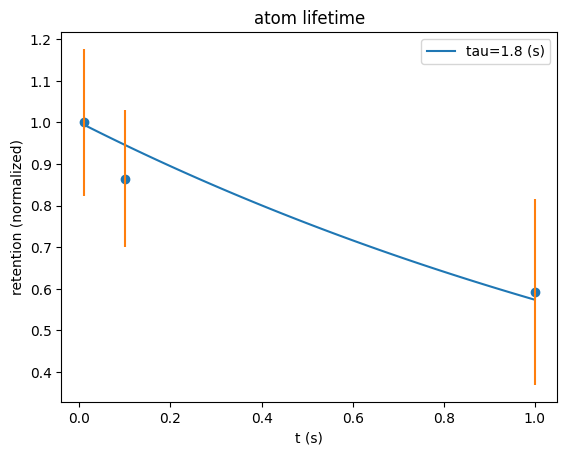

In [275]:
plt.scatter(t_delay_arr, retention_array/retention_array[0])
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
tau = 1.8
plt.title('atom lifetime')
plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.errorbar(t_delay_arr,retention_array/retention_array[0],1/np.sqrt(n_atoms_loaded_array),ls='none')
plt.ylabel("retention (normalized)")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
plt.legend()

#### check if the atom lifetime is suffering due to the heating from the readout
by comparing two lifetime experiments with only a 0.5 s holding time, but one has no first readout.

In [175]:
datestr = "2023-11-20"
files = [h5py.File(os.path.join(results, datestr, file)) for file in ["16\\000007885-SingleAtomTrapLifetime.h5","16\\000007886-SingleAtomTrapLifetime.h5"]]
# [x for x in f['datasets']]

True


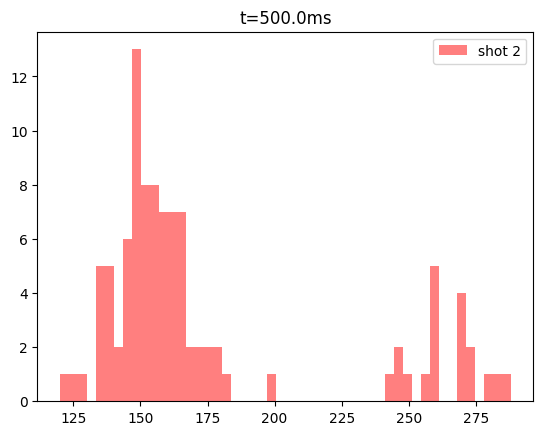

False


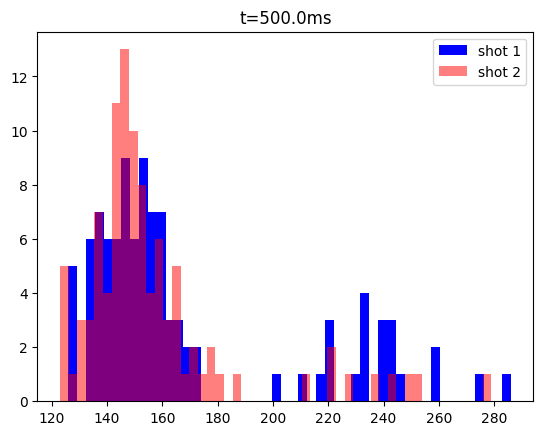

In [179]:
for f in files:

    n_measurements = np.uint(f['datasets']['n_measurements'])
    counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
    counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
    t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots'])
    no_first_shot = np.bool_(f['datasets']['no_first_shot'])
    print(no_first_shot)
    
    # plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
    cutoff = [200]
    retention_array = np.zeros(len(t_delay_arr))
    loading_rate_array = np.zeros(len(t_delay_arr))
    
    for i,t in enumerate(t_delay_arr):
        shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
        shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
        if not no_first_shot:
            plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1),label='shot 1')
        plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5),label='shot 2') #edgecolor=(1, 0.5, 0.2, 1),
        plt.title(f"t={t/ms}ms")
        plt.legend()
        plt.show()
        atoms_loaded = [x > cutoff[i] for x in shot1]
        n_atoms_loaded = sum(atoms_loaded)
        atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
        retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
        retention_array[i] = retention_fraction
        loading_rate_array[i] = n_atoms_loaded/n_measurements 

#### the first experiment to measure the lifetime of our single atoms in the dipole trap

In [180]:
# the measurement from Friday night
f = h5py.File(os.path.join(results, "2023-11-17\\17\\000007857-SingleAtomTrapLifetime.h5"))
[x for x in f['datasets']]

['AOM_A1_power',
 'AOM_A2_power',
 'AOM_A3_power',
 'AOM_A4_power',
 'AOM_A5_power',
 'AOM_A6_power',
 'FORT_monitor',
 'MOT1_monitor',
 'MOT2_monitor',
 'MOT3_monitor',
 'MOT4_monitor',
 'MOT5_monitor',
 'MOT6_monitor',
 'MOT_switchyard_monitor',
 'atom_counts_threshold',
 'atom_retention',
 'bins',
 'do_PGC_after_loading',
 'n_measurements',
 'no_first_shot',
 'p_cooling_DP_MOT',
 'photocount_bins',
 'photocounts',
 'photocounts2',
 'scan_datasets',
 't_delay_between_shots']

In [182]:
n_measurements = np.uint(f['datasets']['n_measurements'])
counts_shot1 = np.array(f['datasets']['photocounts'])[1:]
counts_shot2 = np.array(f['datasets']['photocounts2'])[1:]
t_delay_arr = eval_str_from_h5(f['datasets']['t_delay_between_shots'])

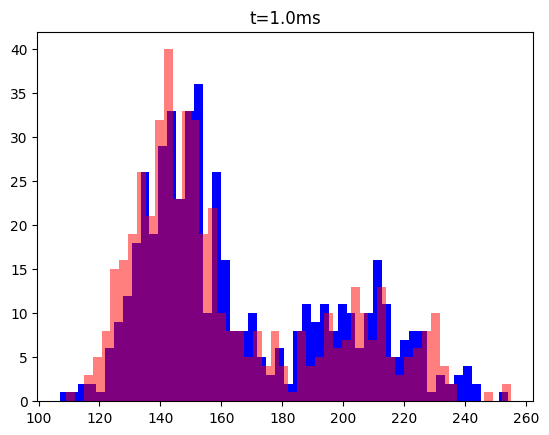

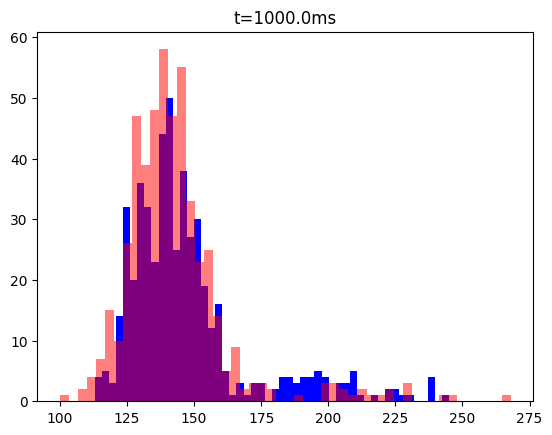

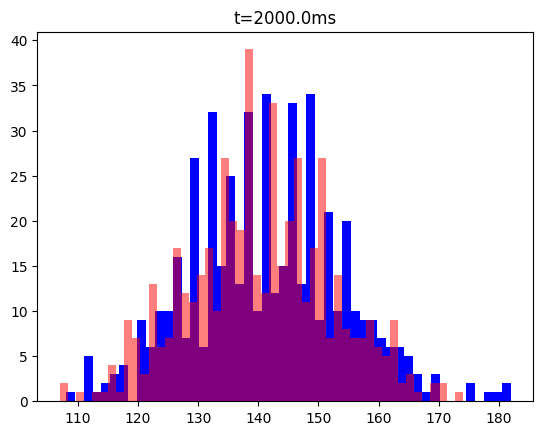

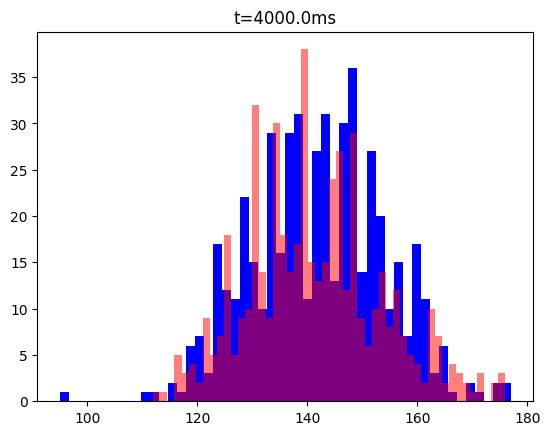

In [183]:
# plot histogram for each iteration (iteration = experiment sequence with a particular gap time between shots)
cutoff = [180,175,175,175]
retention_array = np.zeros(len(t_delay_arr))
loading_rate_array = np.zeros(len(t_delay_arr))
n_atoms_loaded_array = np.zeros(len(t_delay_arr))

for i,t in enumerate(t_delay_arr):
    shot1 = counts_shot1[i*n_measurements:(i+1)*n_measurements]
    shot2 = counts_shot2[i*n_measurements:(i+1)*n_measurements]
    plt.hist(shot1,bins=50, facecolor=(0.0, 0.0, 1.0, 1))
    plt.hist(shot2,bins=50, facecolor=(1.0, 0.0, 0.0, 0.5)) #edgecolor=(1, 0.5, 0.2, 1),
    plt.title(f"t={t/ms}ms")
    plt.show()
    atoms_loaded = [x > cutoff[i] for x in shot1]
    n_atoms_loaded = sum(atoms_loaded)
    atoms_retained = [x > cutoff[i] and y for x,y in zip(shot2, atoms_loaded)]
    retention_fraction = 0 if not n_atoms_loaded > 0 else sum(atoms_retained)/sum(atoms_loaded)
    retention_array[i] = retention_fraction
    loading_rate_array[i] = n_atoms_loaded/n_measurements
    n_atoms_loaded_array[i] = n_atoms_loaded

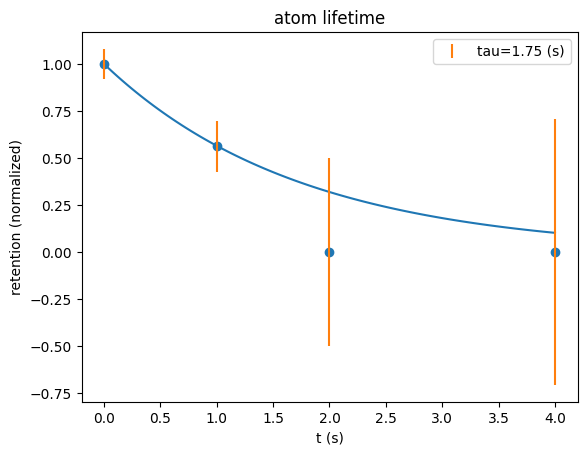

In [193]:
plt.scatter(t_delay_arr, retention_array/retention_array[0])
t_pts = np.linspace(t_delay_arr[0],t_delay_arr[-1],100)
tau = 1.75
plt.title('atom lifetime')
plt.plot(t_pts,np.exp(-t_pts/tau))#,label=f"tau={tau} (s)")
plt.errorbar(t_delay_arr,retention_array/retention_array[0],1/np.sqrt(n_atoms_loaded_array),ls='none',label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("t (s)")
# plt.xlim((0,1.1))
plt.legend()

Text(0.5, 0, 'minutes')

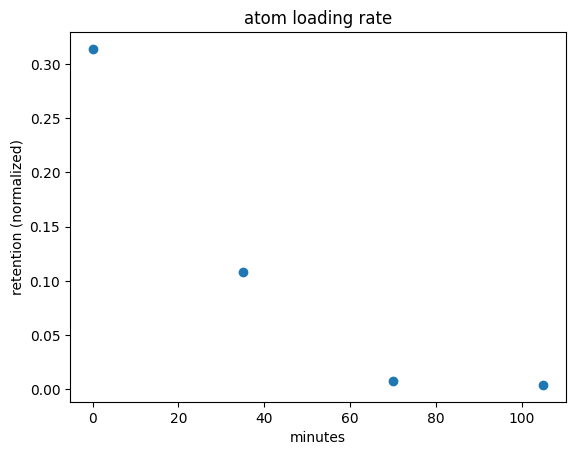

In [103]:
time = np.linspace(0,60+45,4)
plt.scatter(time,loading_rate_array)
plt.title('atom loading rate')
# plt.plot(t_pts,np.exp(-t_pts/tau),label=f"tau={tau} (s)")
plt.ylabel("retention (normalized)")
plt.xlabel("minutes")